# Demo Variance Bias Tradeoff

In [1]:
# this code is adopted from: http://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html
# print(__doc__)

# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# # Change this for exploring the bias-variance decomposition of other
# # estimators. This should work well for estimators with high variance (e.g.,
# # decision trees or KNN), but poorly for estimators with low variance (e.g.,
# # linear models).
# param = {'criterion':'friedman_mse', 'min_samples_split':2, 'min_samples_leaf':1, 'max_depth':4}
# estimators = [("Tree", DecisionTreeRegressor(**param)),
#               ("Bagging(Tree)", BaggingRegressor(n_estimators=100,base_estimator=DecisionTreeRegressor(**param))),
#              ("RandomForest(Tree)",RandomForestRegressor(n_estimators=100, **param)),
#              ("Boosting(Tree)",GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, **param))]

def compare_estimators(estimators):
    n_estimators = len(estimators)

    # Generate data
    def f(x):
        x = x.ravel()

        return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

    def generate(n_samples, noise, n_repeat=1):
        X = np.random.rand(n_samples) * 10 - 5
        X = np.sort(X)

        if n_repeat == 1:
            y = f(X) + np.random.normal(0.0, noise, n_samples)
        else:
            y = np.zeros((n_samples, n_repeat))

            for i in range(n_repeat):
                y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

        X = X.reshape((n_samples, 1))

        return X, y

    X_train = []
    y_train = []

    for i in range(n_repeat):
        X, y = generate(n_samples=n_train, noise=noise)
        X_train.append(X)
        y_train.append(y)

    X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

    # Loop over estimators to compare
    for n, (name, estimator) in enumerate(estimators):
        # Compute predictions
        y_predict = np.zeros((n_test, n_repeat))

        for i in range(n_repeat):
            estimator.fit(X_train[i], y_train[i])
            y_predict[:, i] = estimator.predict(X_test)

        # Bias^2 + Variance + Noise decomposition of the mean squared error
        y_error = np.zeros(n_test)

        for i in range(n_repeat):
            for j in range(n_repeat):
                y_error += (y_test[:, j] - y_predict[:, i]) ** 2

        y_error /= (n_repeat * n_repeat)

        y_noise = np.var(y_test, axis=1)
        y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
        y_var = np.var(y_predict, axis=1)

        print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
              " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                          np.mean(y_error),
                                                          np.mean(y_bias),
                                                          np.mean(y_var),
                                                          np.mean(y_noise)))


        # Plot figures
        plt.subplot(2, n_estimators, n + 1)
        plt.plot(X_test, f(X_test), "b", label="$f(x)$")
        plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

        for i in range(n_repeat):
            if i == 0:
                plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
            else:
                plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

        plt.plot(X_test, np.mean(y_predict, axis=1), "c",
                 label="$\mathbb{E}_{LS} \^y(x)$")

        plt.xlim([-5, 5])
        plt.title(name)

        if n == 0:
            plt.legend(loc="upper left", prop={"size": 11})

        plt.subplot(2, n_estimators, n_estimators + n + 1)
        plt.plot(X_test, y_error, "r", label="$error(x)$")
        plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
        plt.plot(X_test, y_var, "g", label="$variance(x)$"),
        plt.plot(X_test, y_noise, "c", label="$noise(x)$")

        plt.xlim([-5, 5])
        plt.ylim([0, 0.1])

        if n == 0:
            plt.legend(loc="upper left", prop={"size": 11})

    plt.show()

Tree: 0.0565 (error) = 0.0264 (bias^2)  + 0.0198 (var) + 0.0098 (noise)
Bagging(Tree): 0.0433 (error) = 0.0232 (bias^2)  + 0.0098 (var) + 0.0098 (noise)
RandomForest(Tree): 0.0434 (error) = 0.0234 (bias^2)  + 0.0098 (var) + 0.0098 (noise)
Boosting(Tree): 0.0211 (error) = 0.0005 (bias^2)  + 0.0105 (var) + 0.0098 (noise)


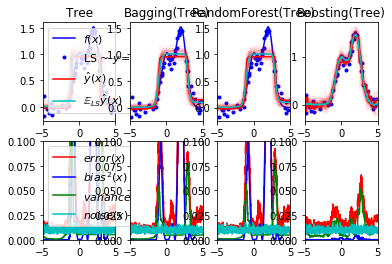

In [2]:
# for weak learners, shallow/simple trees (high bias weak learners):
# Bagging/RF lowered variance significantly (~2x), and slightly lowered bias
# Boosting lowered bias significantly (~10x), and slightly lowered vairiance
param = {'criterion':'friedman_mse', 'min_samples_split':2, 'min_samples_leaf':1, 'max_depth':2}
estimators = [("Tree", DecisionTreeRegressor(**param)),
              ("Bagging(Tree)", BaggingRegressor(n_estimators=100,base_estimator=DecisionTreeRegressor(**param))),
             ("RandomForest(Tree)",RandomForestRegressor(n_estimators=100, **param)),
             ("Boosting(Tree)",GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, **param))]

compare_estimators(estimators)

Tree: 0.0245 (error) = 0.0004 (bias^2)  + 0.0140 (var) + 0.0099 (noise)
Bagging(Tree): 0.0182 (error) = 0.0006 (bias^2)  + 0.0075 (var) + 0.0099 (noise)
RandomForest(Tree): 0.0182 (error) = 0.0006 (bias^2)  + 0.0076 (var) + 0.0099 (noise)
Boosting(Tree): 0.0245 (error) = 0.0004 (bias^2)  + 0.0140 (var) + 0.0099 (noise)


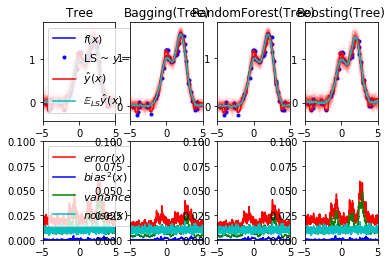

In [3]:
# for strong learners, deep/complex tree (low bias strong learners):
# Bagging/RF lowered variance significantly (~2x), BUT increased bias
# Boosting does NOT lower bias (since bias is already very low), does NOT lower variance (since it's not its main task)
param = {'criterion':'friedman_mse', 'min_samples_split':2, 'min_samples_leaf':1, 'max_depth':10}
estimators = [("Tree", DecisionTreeRegressor(**param)),
              ("Bagging(Tree)", BaggingRegressor(n_estimators=200,base_estimator=DecisionTreeRegressor(**param))),
             ("RandomForest(Tree)",RandomForestRegressor(n_estimators=200, **param)),
             ("Boosting(Tree)",GradientBoostingRegressor(learning_rate=0.03, n_estimators=500, **param))]

compare_estimators(estimators)

In [4]:
"""
Summary:

Bagging/RF: 
  Mainly lower variance
  MAY slightly increase bias for low bias strong learners, MAY slightly decrease bias for high bias weak learners
  Since RF mainly works with strong learner, more often than not, it will increase bias
Boosting:
  Mainly lowers bias for high bias weak learners, but not much for lower bias strong learners
  May slightly lower variance for high bias weak learners, but not much for lower bias strong learners (not sure), 
    because not much to boost when bias is already low.
Note:
  test case isn't for testing RF, since the data only has one independent variable, RF is pretty much bagging
"""

"\nSummary:\n\nBagging/RF: \n  Mainly lower variance\n  MAY slightly increase bias for low bias strong learners, MAY slightly decrease bias for high bias weak learners\n  Since RF mainly works with strong learner, more often than not, it will increase bias\nBoosting:\n  Mainly lowers bias for high bias weak learners, but not much for lower bias strong learners\n  May slightly lower variance for high bias weak learners, but not much for lower bias strong learners (not sure), \n    because not much to boost when bias is already low.\nNote:\n  test case isn't for testing RF, since the data only has one independent variable, RF is pretty much bagging\n"